# Imports

In [1]:
# Add module files on path
import sys
sys.path.append('./modules')

# Importing
import cv2
import torch
import numpy as np
from model import Model
from scipy import ndimage
from torch.utils.data import DataLoader, random_split
from dataset import MyDecDataset, MySegDataset, MyDataLoader
from visualize import show_labeled_image,show_image_and_seg,show_image_and_probmap
from helpers import xml_to_csv,reverse_normalize,total_variation,to_device,get_predicted_centers,accuracy,to_device

torch.manual_seed(24)

# Datasets

## Detection Dataset

In [2]:
batch_size = 16

In [3]:
# Choose device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [4]:
# Convert XML files to CSV to create dataset
xml_to_csv('./Dataset/blob/**/*.xml', 'labels.csv')

Processed:  8737  images


In [5]:
# Create custom dataset class
dataset_dt = MyDecDataset('labels.csv')

In [6]:
# Split dataset
train_size = int(0.7 * len(dataset_dt))
test_size = int(0.15 * len(dataset_dt))
validation_size = len(dataset_dt) - (train_size + test_size)

train_dt, validation_dt, test_dt = random_split(dataset_dt, [train_size, validation_size, test_size])

In [7]:
print("Size of detection test set", len(test_dt))
print("Size of detection training set:", len(train_dt))
print("Size of detection validation set:", len(validation_dt))

Size of detection test set 1310
Size of detection training set: 6116
Size of detection validation set: 1312


In [8]:
test_loader_dt = DataLoader(test_dt, batch_size=batch_size, shuffle=True)
train_loader_dt = DataLoader(train_dt, batch_size=batch_size, shuffle=True)
validation_loader_dt = DataLoader(validation_dt, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape:  torch.Size([16, 3, 480, 640])
Shape:  torch.Size([16, 3, 480, 640])
Accuracy:  (1.0, 1.0)


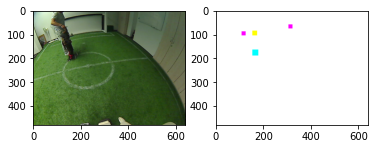

In [9]:
# Display first training image
for images, targets in train_loader_dt:
    print("Shape: ", images.shape)
    print("Shape: ", targets.shape)
    
    print("Accuracy: ", accuracy(targets, targets))
        
    show_image_and_probmap(images[0], targets)
    break

## Segmentation Dataset

In [10]:
# Create custom dataset
dataset_seg = MySegDataset('./Dataset/segmentation') # or define the w, and the h

In [11]:
print("Size of segmentation dataset ", len(dataset_seg))

Size of segmentation dataset  1192


In [12]:
# Split dataset
train_size = int(0.7 * len(dataset_seg))
test_size = int(0.15 * len(dataset_seg))
validation_size = len(dataset_seg) - (train_size + test_size)

train_seg, validation_seg, test_seg = random_split(dataset_seg, [train_size, validation_size, test_size])

In [13]:
print("Size of segmentation test set", len(test_seg))
print("Size of detection training set:", len(train_seg))
print("Size of detection validation set:", len(validation_seg))

Size of segmentation test set 178
Size of detection training set: 834
Size of detection validation set: 180


Target Shape:  torch.Size([1, 480, 640])
Image Shape:  torch.Size([3, 480, 640])


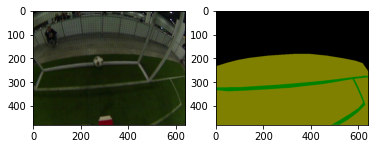

In [14]:
# Create dataloader for segmentation data
test_loader_seg = DataLoader(test_seg, batch_size=batch_size, shuffle=True)
train_loader_seg = DataLoader(train_seg, batch_size=batch_size, shuffle=True)
validation_loader_seg = DataLoader(validation_seg, batch_size=batch_size, shuffle=True)

# Just as a sanity check display the test set
for image, target in train_loader_seg:
    print("Target Shape: ", target[0].shape)
    print("Image Shape: ", image[0].shape)
        
    show_image_and_seg(image[0],target[0])

    break

### Model

In [15]:
# This is just a testing arena, not doing anything meaningful
model = Model(device,640,480)
model = to_device(model, device)
test_seg_data_loader = DataLoader(test_seg, batch_size=1, shuffle=True)
for _, (images, targets) in enumerate (test_seg_data_loader):
    images = to_device(images,device)
    targets = to_device(targets,device)
    print("Size of input",images[0].shape)
    print("Size of target",targets[0].shape)
    downsampled_target =  torch.nn.UpsamplingNearest2d(scale_factor=0.25)(targets)
    print("Size of target after downsampling",downsampled_target.shape)
    output = model(images,head="segmentation")
    print("Size of model ouput",output.shape)
    downsampled_target = torch.squeeze(downsampled_target,dim=1) # this is to change the input from (batch_size,1,H,W) -> (batch_size,H,W)
    downsampled_target = downsampled_target.type(torch.LongTensor) # convert the target from float to int
    downsampled_target = to_device(downsampled_target,device)
    print("Size of target after squeeze",downsampled_target.shape)
    nll_loss = torch.nn.NLLLoss()
    softmax = torch.nn.LogSoftmax(dim=1) # wait for hafez reply if it is needed or not
    softmax_output = softmax(output)
    _,predicted = torch.max(output, 1)
    print("Size of prediction",predicted.shape)
    correct = (predicted == downsampled_target).sum().item()
    print(correct)
    print("total",downsampled_target.size(2))
    print("Accuaracy:",correct/(downsampled_target.size(1)*downsampled_target.size(2)))
    total_loss = nll_loss(softmax_output, downsampled_target) + total_variation(output,0)+ total_variation(output,1) # also not sure if should be applied on output before or after softmax
    total_loss.backward()
    
    print(total_loss)
    break;
    

Size of input torch.Size([3, 480, 640])
Size of target torch.Size([1, 480, 640])
Size of target after downsampling torch.Size([1, 1, 120, 160])


/home/user/shoeb/cuda-vision-lab/lib/python3.6/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.76 GiB total capacity; 157.11 MiB already allocated; 4.62 MiB free; 166.00 MiB reserved in total by PyTorch)

# Train

In [15]:
# Model
#model = Model(device,640,480)
model = Model(device,160,128) # Now we initialize the bias with the smallest, value, and then it is automatically increment when a larger image is passed 
model = to_device(model, device)

In [16]:
# Training parameters
epochs = 150
learning_rate = 0.1
optimizer_encoder = torch.optim.Adam(model.encoder.parameters(), learning_rate, weight_decay=0.001)
optimizer_decoder = torch.optim.Adam(model.decoder.parameters(), learning_rate, weight_decay=0.001)
scheduler_encoder = torch.optim.lr_scheduler.CyclicLR(optimizer_encoder,cycle_momentum=False,base_lr=1e-3,max_lr=1e-2,step_size_up=2000)
scheduler_decoder = torch.optim.lr_scheduler.CyclicLR(optimizer_decoder,cycle_momentum=False,base_lr=1e-4,max_lr=1e-3,step_size_up=2000)

In [17]:
# Current iteration
iterations = 0

In [18]:
# Resolution change flags
set_resolution50 = False
set_resolution100 = False
set_resolution150 = False

In [19]:
for epoch in range(epochs):
    # Segmentation and detection
    # cumulative losses
    cum_loss_seg = 0
    cum_loss_det = 0
    
    # Save model every 25 epochs
    if (epoch % 25 == 0 or epoch==149):
        torch.save(model.state_dict(), f"/home/user/shoeb/NimbRoNet2/models/model_schueduler_epoch_{epoch}.pt")
    
    if epoch < 50 and not set_resolution50:
        set_resolution50 = True
        
        # Freeze encoder layers
        model.freeze_encoder()
        
        # Set resolution to quarter of orignal size
        dataset_dt.set_resolution(128,160)
        dataset_seg.set_resolution(128,160)
    elif 50 <= epoch < 100 and not set_resolution100:
        # Unfroze encoder layers
        model.unfreeze_encoder()
        
        # Set resolution to half original size
        dataset_dt.set_resolution(256,320)
        dataset_seg.set_resolution(256,320)
        
        set_resolution100 = True
    elif 100 <= epoch < 150 and not set_resolution150:
        # Set resolution to original size
        dataset_dt.set_resolution(480,640)
        dataset_seg.set_resolution(480,640)
        
        set_resolution150 = True
    
    # Segmentation training
    for batch_idx, batch in enumerate(train_loader_seg):
        batch = to_device(batch,device)
        
        # Clear gradients
        optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()
         
        # Feed forward and get loss
        loss = model.training_step_segmentation(batch)
        
        # Compute gradient
        loss.backward()
        
        # Backprop
        optimizer_encoder.step()
        optimizer_decoder.step()
        scheduler_encoder.step()
        scheduler_decoder.step()
        
        cum_loss_seg += loss.item()/len(batch[0])
    
    # Validation for segmentation
    accuracy,iou = model.validation_segmentation(validation_loader_seg)
    print('SEGMENTATION -> Epoch: {}. Training Loss: {}. Validation Accuracy: {}\n'.format(epoch, cum_loss_seg, accuracy['Total']))
    
    # Detection training
    for batch_idx, batch in enumerate(train_loader_dt):        
        batch = to_device(batch,device)
        
        # Clear gradients
        optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()
        
        # Feed forward and get loss
        loss = model.training_step_detection(batch)
        
        # Compute gradient
        loss.backward()
        
        # Backprop
        optimizer_encoder.step()
        optimizer_decoder.step()
        scheduler_encoder.step()
        scheduler_decoder.step()
        
        cum_loss_det +=loss.item()/len(batch[0])
    
    # Validation for detection
    #precision, recall = model.validation_detection(validation_loader_dt)
    print('DETECTION -> Epoch: {}. Training Loss: {}. Validation Precision: {}. Validation Recall: {}\n'.format(epoch, 
                                                                                                                cum_loss_det, 
                                                                                                                0,
                                                                                                                0))

SEGMENTATION -> Epoch: 0. Training Loss: 12.462301656603813. Validation Accuracy: 70.71440972222223

DETECTION -> Epoch: 0. Training Loss: 71.02965173870325. Validation Precision: 0. Validation Recall: 0

SEGMENTATION -> Epoch: 1. Training Loss: 3.9114871583878994. Validation Accuracy: 91.20963541666667

DETECTION -> Epoch: 1. Training Loss: 7.951696899719536. Validation Precision: 0. Validation Recall: 0

SEGMENTATION -> Epoch: 2. Training Loss: 1.9432262275367975. Validation Accuracy: 92.84939236111111

DETECTION -> Epoch: 2. Training Loss: 2.33267838973552. Validation Precision: 0. Validation Recall: 0

SEGMENTATION -> Epoch: 3. Training Loss: 1.5117626935243607. Validation Accuracy: 93.95052083333333

DETECTION -> Epoch: 3. Training Loss: 0.9438213700195774. Validation Precision: 0. Validation Recall: 0

SEGMENTATION -> Epoch: 4. Training Loss: 1.3293680027127266. Validation Accuracy: 94.6796875

DETECTION -> Epoch: 4. Training Loss: 0.774365613469854. Validation Precision: 0. Vali

KeyboardInterrupt: 

"""
for _, (images, targets) in enumerate (train_loader_seg):
    images = to_device(images,device)
    targets = to_device(targets,device)
    output = model(images,head="segmentation")
    softmax_output = softmax(output)
    _,predicted = torch.max(output, 1)
    target = targets.cpu()
    image = images.cpu()
    predicted = predicted.cpu()
    show_image_and_seg(image[0],target[0])
    show_image_and_seg(image[0],predicted)
    break
"""

## Evaluate and visualize

In [23]:
model = Model(device,160,128)
model = to_device(model, device)
model.load_state_dict(torch.load("/home/user/shoeb/NimbRoNet2/models/model_schueduler_epoch_25.pt"), strict=False)
accuracy,iou = model.validation_segmentation(test_loader_seg)
print('Accuracy',accuracy)
print('IOU',iou)
acc=model.validation_detection(test_loader_dt)

print(acc)

Accuracy {'Total': 92.05933988764045, 'Field': 95.21792497676365, 'Lines': 31.31552248900913, 'Background': 93.25993899469408}
IOU {'Field': 0.885670540563728, 'Lines': 0.2894352990206293, 'Background': 0.8580305870977631, 'Total': 0.6777121422273735}
(0.35856109086673227, 0.16398562386405754)


In [ ]:
for image, target in test_loader_seg:    
    
    image_gpu = to_device(image,device)
    output = model(image_gpu,head="segmentation")
    
    
    softmax = torch.nn.LogSoftmax(dim=1) # wait for hafez reply if it is needed or not
    softmax_output = softmax(output)
            
    # Get predictions from the maximum value
    _, predicted = torch.max(softmax_output, 1)
    
    predicted = predicted.detach()
    show_image_and_seg(image[0],target[0])
    show_image_and_seg(image[0],predicted.cpu())
    break
    
    